# Setting Up Our Workspace.

#### Importing necessary libraries

In [1]:
from importlib import reload
# custom functions 
import helper_functions as hf

import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import pandas as pd
import seaborn as sns

import scipy.stats as scs
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')
reload(hf )

<module 'helper_functions' from 'C:\\Users\\Owner\\Desktop\\Data Science\\Flatiron_Projects\\dsc-mod-3-project-online-ds-ft-090919\\helper_functions.py'>

#### Setting Up The Connection to the Database

In [2]:
# Setting up the connection to the database
conn, cursor = hf.connection()

In [3]:
hf.get_tables(cursor)

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

# Q2 - We are going to investigate the effect region has on the sales per unit. Is it more profitable to sell Locally, or Abroad?

H0 - Region does __NOT__ have a statistically significant effect on sales per unit.<br>
HA - Region __DOES__ have a statistically significant effect on sales per unit.

In [4]:
query = ('''SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount, 
(od.Quantity * od.UnitPrice * (1-od.Discount)) PriceperOrder FROM Customer c 
JOIN [Order] o on c.Id=o.CustomerId
JOIN [OrderDetail] od on od.OrderId=o.Id''')
df = hf.query_to_df(query, conn)
df.head()

,Region,OrderId,Quantity,UnitPrice,Discount,PriceperOrder
0,Western Europe,10248,12,14.0,0.0,168.0
1,Western Europe,10248,10,9.8,0.0,98.0
2,Western Europe,10248,5,34.8,0.0,174.0
3,Western Europe,10249,9,18.6,0.0,167.4
4,Western Europe,10249,40,42.4,0.0,1696.0


Lets engineer a feature which calcultes the average price per unit.

In [5]:
df['PriceperUnit'] = df.apply(lambda row: row['PriceperOrder'] / row['Quantity'], axis=1)
df.head()

,Region,OrderId,Quantity,UnitPrice,Discount,PriceperOrder,PriceperUnit
0,Western Europe,10248,12,14.0,0.0,168.0,14.0
1,Western Europe,10248,10,9.8,0.0,98.0,9.8
2,Western Europe,10248,5,34.8,0.0,174.0,34.8
3,Western Europe,10249,9,18.6,0.0,167.4,18.6
4,Western Europe,10249,40,42.4,0.0,1696.0,42.4


Let's take a look at the data

In [6]:
df.Region.unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 7 columns):
Region           2078 non-null object
OrderId          2078 non-null int64
Quantity         2078 non-null int64
UnitPrice        2078 non-null float64
Discount         2078 non-null float64
PriceperOrder    2078 non-null float64
PriceperUnit     2078 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 113.7+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C39DA125F8>,
      dtype=object)

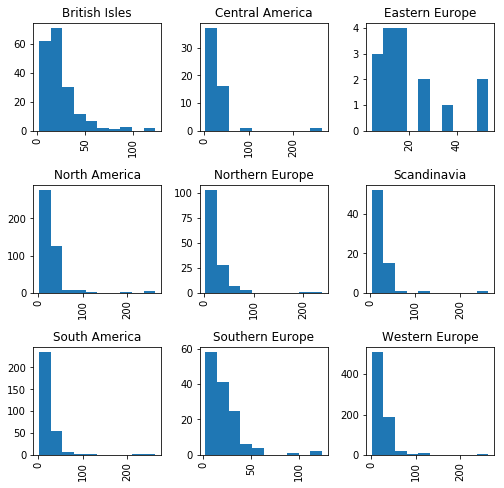

In [8]:
df.hist('PriceperUnit', by='Region', figsize=(8,8), bins=10)

Lets check to see if the data is normally distributed.  From the histograms above, it appears that it is not, but we will use the Shapiro Test to check.

In [9]:
british_isles = df.loc[df['Region'] == 'British Isles']
central_america = df.loc[df['Region'] == 'Central America']
eastern_europe = df.loc[df['Region'] == 'Eastern Europe']
north_america = df.loc[df['Region'] == 'North America']
northern_europe = df.loc[df['Region'] == 'Northern Europe']
scandinavia = df.loc[df['Region'] == 'Scandinavia']
south_america = df.loc[df['Region'] == 'South America']
southern_europe = df.loc[df['Region'] == 'Southern Europe']
western_europe = df.loc[df['Region'] == 'Western Europe']

british_isles = british_isles['PriceperUnit']
central_america = central_america['PriceperUnit']
eastern_europe = eastern_europe['PriceperUnit']
north_america = north_america['PriceperUnit']
northern_europe = northern_europe['PriceperUnit']
scandinavia = scandinavia['PriceperUnit']
south_america = south_america['PriceperUnit']
southern_europe = southern_europe['PriceperUnit']
western_europe = western_europe['PriceperUnit']

print('british_isles')
print(hf.test_normality(british_isles))
print('central_america')
print(hf.test_normality(central_america))
print('eastern_europe')
print(hf.test_normality(eastern_europe))
print('north_america')
print(hf.test_normality(north_america))
print('northern_europe')
print(hf.test_normality(northern_europe))
print('scandinavia')
print(hf.test_normality(scandinavia))
print('south_america')
print(hf.test_normality(south_america))
print('southern_europe')
print(hf.test_normality(southern_europe))
print('western_europe')
print(hf.test_normality(western_europe))



british_isles
p= 3.3124803648221636e-16
 The data is not normally distributed.
False
central_america
p= 7.305543431486428e-13
 The data is not normally distributed.
False
eastern_europe
p= 0.02098287083208561
 The data is not normally distributed.
False
north_america
p= 2.026530954982515e-32
 The data is not normally distributed.
False
northern_europe
p= 1.859561212131792e-19
 The data is not normally distributed.
False
scandinavia
p= 1.597113995146105e-14
 The data is not normally distributed.
False
south_america
p= 1.4154092495539283e-29
 The data is not normally distributed.
False
southern_europe
p= 6.458760054019706e-15
 The data is not normally distributed.
False
western_europe
p= 2.354950732922607e-39
 The data is not normally distributed.
False


We have determined that the data is __NOT__ normally distributed.
We will perform a sampling distribution to get it more normal

In [10]:
british_islesmean = np.mean(british_isles)
british_islesstd = np.std(british_isles, ddof=1)

samp_british_isles = np.random.normal(loc=british_islesmean, scale=british_islesstd, size=100)

central_americamean = np.mean(central_america)
central_americastd = np.std(central_america, ddof=1)

samp_central_america = np.random.normal(loc=central_americamean, scale=central_americastd, size=100)

eastern_europemean = np.mean(eastern_europe)
eastern_europestd = np.std(eastern_europe, ddof=1)

samp_eastern_europe = np.random.normal(loc=eastern_europemean, scale=eastern_europestd, size=100)

north_americamean = np.mean(north_america)
north_americastd = np.std(north_america, ddof=1)

samp_north_america = np.random.normal(loc=north_americamean, scale=north_americastd, size=100)

northern_europemean = np.mean(northern_europe)
northern_europestd = np.std(northern_europe, ddof=1)

samp_northern_europe = np.random.normal(loc=northern_europemean, scale=northern_europestd, size=100)

scandinaviamean = np.mean(scandinavia)
scandinaviastd = np.std(scandinavia, ddof=1)

samp_scandinavia = np.random.normal(loc=scandinaviamean, scale=scandinaviastd, size=100)

south_americamean = np.mean(south_america)
south_americastd = np.std(south_america, ddof=1)

samp_south_america = np.random.normal(loc=south_americamean, scale=south_americastd, size=100)

southern_europemean = np.mean(southern_europe)
southern_europestd = np.std(southern_europe, ddof=1)

samp_southern_europe = np.random.normal(loc=southern_europemean, scale=southern_europestd, size=100)

western_europemean = np.mean(western_europe)
western_europestd = np.std(western_europe, ddof=1)

samp_western_europe = np.random.normal(loc=western_europemean, scale=western_europestd, size=100)

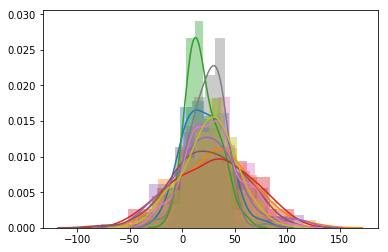

In [11]:

sns.distplot(samp_british_isles)
sns.distplot(samp_central_america)
sns.distplot(samp_eastern_europe)
sns.distplot(samp_north_america)
sns.distplot(samp_northern_europe)
sns.distplot(samp_scandinavia)
sns.distplot(samp_south_america)
sns.distplot(samp_southern_europe)
sns.distplot(samp_western_europe)

It looks as though the data is more normal now, but we will double check with the Shapiro test.

In [12]:
hf.test_normality(samp_british_isles)
hf.test_normality(samp_central_america)
hf.test_normality(samp_eastern_europe)
hf.test_normality(samp_north_america)
hf.test_normality(samp_northern_europe)
hf.test_normality(samp_scandinavia)
hf.test_normality(samp_south_america)
hf.test_normality(samp_southern_europe)
hf.test_normality(samp_western_europe)

p= 0.606888473033905
 The data is normally distributed.
p= 0.830079197883606
 The data is normally distributed.
p= 0.029410546645522118
 The data is not normally distributed.
p= 0.43753236532211304
 The data is normally distributed.
p= 0.07742969691753387
 The data is normally distributed.
p= 0.8787531852722168
 The data is normally distributed.
p= 0.20757952332496643
 The data is normally distributed.
p= 0.09668848663568497
 The data is normally distributed.
p= 0.8561683893203735
 The data is normally distributed.


True

We have confirmed that our data is now normally distributed, now we will test our Hypothesis

In [13]:
region_samples = pd.DataFrame()
region_samples['samp_british_isles'] = samp_british_isles
region_samples['samp_central_america'] = samp_central_america
region_samples['samp_eastern_europe'] = samp_eastern_europe
region_samples['samp_north_america'] = samp_north_america
region_samples['samp_northern_europe'] = samp_northern_europe
region_samples['samp_scandinavia'] = samp_scandinavia
region_samples['samp_south_america'] = samp_south_america
region_samples['samp_southern_europe'] = samp_southern_europe
region_samples['samp_western_europe'] = samp_western_europe

In [14]:
region_samples.head()

,samp_british_isles,samp_central_america,samp_eastern_europe,samp_north_america,samp_northern_europe,samp_scandinavia,samp_south_america,samp_southern_europe,samp_western_europe
0,50.217714,127.657410,11.948149,-3.696911,45.902095,20.033270,5.940535,29.761362,20.560046
1,10.625702,1.970120,10.995228,18.146340,1.590990,56.995074,-16.985429,2.966174,23.447324
2,16.787555,55.045161,44.358515,24.175511,13.989384,41.446925,41.186717,38.969891,4.879792
3,26.079643,85.121961,8.757526,43.228372,10.846318,57.400562,24.073041,23.621986,48.903221
4,-4.993002,28.579559,61.575860,10.773853,110.721228,24.479860,9.826069,31.812188,16.644087


Here we will perform an Anova test

In [15]:
formula = 'samp_north_america ~ samp_central_america + samp_eastern_europe + samp_british_isles + samp_northern_europe + samp_scandinavia + samp_south_america + samp_southern_europe + samp_western_europe'
lm = ols(formula, region_samples).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     samp_north_america   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.8188
Date:                Wed, 13 Nov 2019   Prob (F-statistic):              0.588
Time:                        09:44:30   Log-Likelihood:                -497.16
No. Observations:                 100   AIC:                             1012.
Df Residuals:                      91   BIC:                             1036.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               23.7837     10.690      2.225      0.029       2.550      45.017
samp_central_america     0.0163      0.108      0.151      0.880      -0.198       0.230
samp_eastern_europe     -0.2636      0.264     -0.998      0.321      -0.788       0.261
samp_british_isles      -0.2284      0.204     -1.120      0.266      -0.633       0.177
samp_northern_europe     0.0116      0.119      0.097      0.923      -0.225       0.248
samp_scandinavia        -0.0176      0.124     -0.142      0.887      -0.264       0.229
samp_south_america      -0.0683      0.146     -0.469      0.640      -0.357       0.221
samp_southern_europe     0.5369      0.248      2.164      0.033       0.044       1.030
samp_western_europe      0.1857      0.150      1.242      0.217      -0.111       0.483
==============================================================================
Omnibus:                        5.018   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                2.544
Skew:                          -0.089   Prob(JB):                        0.280
Kurtosis:                       2.239   Cond. No.                         229.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                             sum_sq    df         F    PR(>F)
samp_central_america      30.677967   1.0  0.022911  0.880025
samp_eastern_europe     1334.445297   1.0  0.996579  0.320787
samp_british_isles      1679.459517   1.0  1.254240  0.265691
samp_northern_europe      12.707377   1.0  0.009490  0.922610
samp_scandinavia          27.035887   1.0  0.020191  0.887320
samp_south_america       295.098197   1.0  0.220383  0.639871
samp_southern_europe    6272.201650   1.0  4.684154  0.033060
samp_western_europe     2066.347946   1.0  1.543173  0.217338
Residual              121851.332931  91.0       NaN       NaN


From this test we see the probability factor of a few of these is above .05 so we can __reject the Null hypothesis H0.__